# SQL Injection Detection – Extended Analysis
Полный ноутбук с манипуляциями данных и моделями как в Kaggle:
- Feature engineering
- TF-IDF + дополнительные признаки
- RF, SVM, CNN, LSTM, Ensemble
- Confusion Matrix, Accuracy/Loss, Feature Importance


In [1]:
import pandas as pd
import numpy as np
import re, urllib.parse
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from scipy.sparse import hstack
import joblib


## Загрузка и очистка датасета

In [3]:
df = pd.read_csv('Modified_SQL_Dataset.csv')
df = df[['Query', 'Label']].dropna().reset_index(drop=True)
df['Label'] = df['Label'].astype(int)
df.head()

,Query,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,AND 1 = utl_inaddr.get_host_address ( ...,1
3,select * from users where id = '1' or @ @1 ...,1
4,"select * from users where id = 1 or 1#"" ( ...",1


## Препроцессинг

In [4]:
def preprocess(text):
    text = str(text).lower()
    text = urllib.parse.unquote(text)
    text = re.sub(r'/\*.*?\*/', ' ', text)
    text = re.sub(r'--.*$', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['clean_text'] = df['Query'].apply(preprocess)
df.head()

,Query,Label,clean_text
0,""" or pg_sleep ( __TIME__ ) --",1,""" or pg_sleep ( __time__ )"
1,create user name identified by pass123 tempora...,1,create user name identified by pass123 tempora...
2,AND 1 = utl_inaddr.get_host_address ( ...,1,and 1 = utl_inaddr.get_host_address ( ( select...
3,select * from users where id = '1' or @ @1 ...,1,select * from users where id = '1' or @ @1 = 1...
4,"select * from users where id = 1 or 1#"" ( ...",1,"select * from users where id = 1 or 1#"" ( unio..."


## Feature Engineering

In [5]:
df['length'] = df['clean_text'].apply(len)
df['num_digits'] = df['clean_text'].apply(lambda x: sum(c.isdigit() for c in x))
df['num_special'] = df['clean_text'].apply(lambda x: sum(not c.isalnum() for c in x))
df['num_quotes'] = df['clean_text'].apply(lambda x: x.count("'") + x.count('"'))
df['num_keywords'] = df['clean_text'].str.count(r'\b(select|union|or|and|drop|sleep|where|from)\b')

## TF-IDF (char-level) + extra features

In [6]:
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2,5), min_df=3, max_features=50000)
X_text = vectorizer.fit_transform(df['clean_text'])
X_extra = df[['length','num_digits','num_special','num_quotes','num_keywords']].values
X = hstack([X_text, X_extra])
y = df['Label']

## Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Random Forest

In [8]:
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print('RF Accuracy:', accuracy_score(y_test, rf_pred))

RF Accuracy: 0.9974126778783958


## SVM

In [9]:
svm = LinearSVC(class_weight='balanced')
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
print('SVM Accuracy:', accuracy_score(y_test, svm_pred))

SVM Accuracy: 0.994340232858991


C:\Users\unive\PycharmProjects\SQL_INJECTION_PROTECTOR_AI_AGENT\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Ensemble

In [10]:
ensemble = VotingClassifier(
    estimators=[('rf', rf), ('svm', svm)], voting='hard'
)
ensemble.fit(X_train, y_train)
ens_pred = ensemble.predict(X_test)
print('Ensemble Accuracy:', accuracy_score(y_test, ens_pred))

C:\Users\unive\PycharmProjects\SQL_INJECTION_PROTECTOR_AI_AGENT\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Ensemble Accuracy: 0.9961190168175937


## Confusion Matrices

In [11]:
for name, preds in {
    'Random Forest': rf_pred,
    'SVM': svm_pred,
    'Ensemble': ens_pred
}.items():
    print(name)
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))

Random Forest
[[3907    1]
 [  15 2261]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3908
           1       1.00      0.99      1.00      2276

    accuracy                           1.00      6184
   macro avg       1.00      1.00      1.00      6184
weighted avg       1.00      1.00      1.00      6184

SVM
[[3895   13]
 [  22 2254]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3908
           1       0.99      0.99      0.99      2276

    accuracy                           0.99      6184
   macro avg       0.99      0.99      0.99      6184
weighted avg       0.99      0.99      0.99      6184

Ensemble
[[3908    0]
 [  24 2252]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3908
           1       1.00      0.99      0.99      2276

    accuracy                           1.00      6184
   macro avg       1

## Feature Importance (Random Forest)

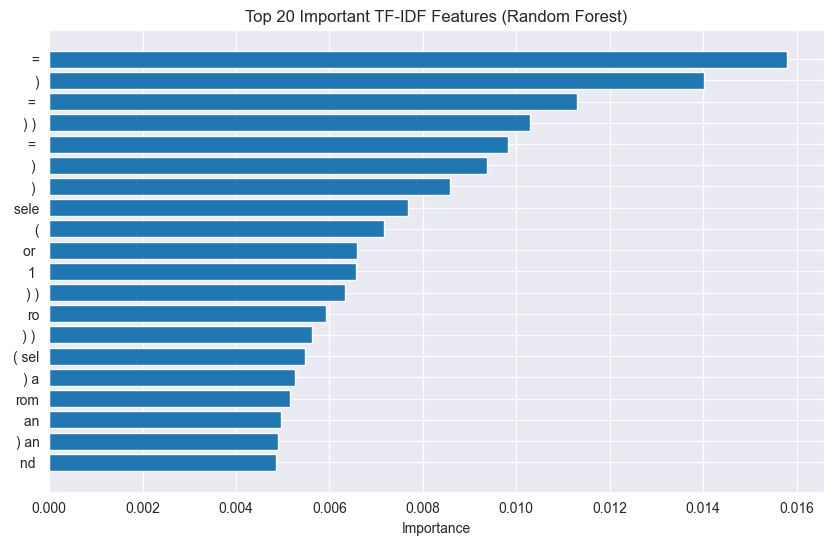

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Количество TF-IDF признаков
n_text_features = X_text.shape[1]

# Берем importance только для TF-IDF
text_importances = rf.feature_importances_[:n_text_features]

indices = np.argsort(text_importances)[-20:]
features = np.array(vectorizer.get_feature_names_out())

plt.figure(figsize=(10,6))
plt.barh(features[indices], text_importances[indices])
plt.title("Top 20 Important TF-IDF Features (Random Forest)")
plt.xlabel("Importance")
plt.show()

## Save Model

In [ ]:
joblib.dump(rf, 'rf_sql_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print('Models saved')

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

cnn = Sequential([
    Embedding(len(tokenizer.word_index)+1, 64, input_length=300),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = cnn.fit(
    X_train_dl, y_train_dl,
    validation_split=0.2,
    epochs=10,
    batch_size=128
)


ModuleNotFoundError: No module named 'tensorflow'